# SOLUTION NOTEBOOK

---

# CIFAR-10 softmax regression

## Exercise - Load and preprocess data

> **Exercise**: Load the data from the `cifar10-6k.npz` file. Split it into train/validation/test sets with respectively 5,000/500/500 images. Standardize them. Define a `get_batches(X, y, batch_size)` function to generate X/y batches of size `batch_size` using a Python generator.

In [5]:
import numpy as np
import os

# Load data
with np.load(os.path.join('cifar10-6k.npz'), allow_pickle=False) as npz_file:
    cifar10 = dict(npz_file.items())

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    cifar10['data'].astype(np.float32),
    cifar10['labels'],
    test_size=1000, random_state=0
)

# Split test into validation/test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test,
    test_size=500, random_state=0
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [7]:
# Function to get batches of data
def get_batches(X, y, batch_size):
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # "yield" data between index i and i+b (not included)
        yield X[i:i+batch_size], y[i:i+batch_size]

## Exercise - Build and train model

> **Exercise:** Create a softmax regression network for the CIFAR-10 images. Define the graph (placeholders, variables, operations, loss function, optimizer) and train it using your batch generator.

**Hint**: Test different learning rates.

In [8]:
import tensorflow as tf

# Create placeholders
X = tf.placeholder(
    dtype=tf.float32,
    shape=[None, 3072] # 32x32x3 = 3072 pixels per image
)
y = tf.placeholder(
    dtype=tf.int32,
    shape=[None] # Vector of target values
)

# Create variables
W = tf.Variable(tf.zeros(shape=(3072, 10)))
b = tf.Variable(tf.zeros(shape=(10)))

# Compute logits
logits = tf.matmul(X, W) + b

# Cross-entropy loss function
ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits)

# Mean cross-entropy
mean_ce = tf.reduce_mean(ce)

# Gradient descent
lr = tf.placeholder(dtype=tf.float32)
gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

# Minimize cross-entropy
train_op = gd.minimize(mean_ce)

# Compute predictions
predictions = tf.argmax(
    logits, # shape: (n, 10)
    axis=1, # class with max logit
    output_type=tf.int32 # Same type as labels
)

# Are the predictions correct?
is_correct = tf.equal(y, predictions)

# Accuracy
accuracy = tf.reduce_mean(
    # Convert booleans to 0/1 float numbers
    tf.cast(is_correct, dtype=tf.float32)
)

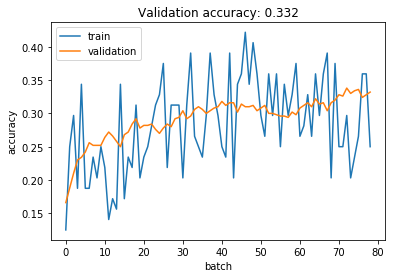

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# Accuracy scores after each batch
train_acc_values = []
valid_acc_values = []

# Initialization operation
initialization_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)
    
    # Get batches of data
    for X_batch, y_batch in get_batches(X_train, y_train, 64):
        # Run training and evaluate accuracy
        _, train_acc = sess.run([train_op, accuracy], feed_dict={
            X: X_batch,
            y: y_batch,
            lr: 0.001 # Learning rate
        })
        train_acc_values.append(train_acc)
        
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)
        
    # Get weight matrix and biases
    W_fitted = W.eval()
    b_fitted = b.eval()

# Plot accuracy values
plt.plot(train_acc_values, label='train')
plt.plot(valid_acc_values, label='validation')
plt.title('Validation accuracy: {:.3f}'.format(
    valid_acc_values[-1] # Last validation accuracy value
))
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Exercise - Plot templates

> **Exercise**: Plot the templates of each output neuron. If you use the `imshow(array)` function to plot the array of weights, remember that it expects values between zero and one for 3-dimensional arrays. You can use the `MinMaxScaler` object from Scikit-learn to rescale the weights.

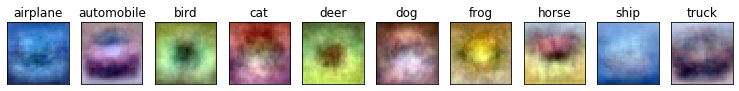

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Rescale each column of the weights matrix between 0 and 1
W_fitted_rescaled = MinMaxScaler().fit_transform(W_fitted)

# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(13, 2))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted_rescaled[:, i]
    
    # Reshape weight values into a 32x32x3 array
    template = weights.reshape(32, 32, 3)
    
    # Plot array
    axis.set_title(cifar10['names'][i])
    axis.imshow(template)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()

## Exercise - Evaluate model

> **Exercise**: Evaluate the accuracy of your network on the test set.

In [11]:
# Initialization operation
initialization_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)
    
    # Compute test accuracy
    acc_val = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test,
        W: W_fitted, # Set weights
        b: b_fitted # Set biases
    })
    print('Test accuracy: {:.3f}'.format(acc_val))

Test accuracy: 0.322
